In [1]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
#SUPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
bike = pd.read_csv("day.csv")
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
bike.shape

(730, 16)

In [5]:
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
#check for null values- no null values in column data
bike.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
#renaming few columns
bike.rename(columns={'yr':'year','mnth':'month','hum':'humidity'},inplace=True)

In [8]:
bike.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [9]:
bike_copy = bike.copy()
bike_copy.shape

(730, 16)

In [10]:
bike_copy.drop_duplicates(inplace=True)
bike_copy.shape

(730, 16)

In [11]:
bike = bike.drop(['registered','instant'],axis=1)

In [12]:
bike = bike.drop('casual',axis=1)

In [13]:
bike = bike.drop('dteday',axis=1)
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [14]:
bike.season = bike.season.map({1:'spring',2:'summer',3:'fall',4:'winter'})

In [15]:
bike.month =bike.month.map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

In [16]:
bike.weekday = bike.weekday.map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})

In [17]:
bike.weathersit =bike.weathersit.map({1:'Clear',2:'Misty',3:'Light_snowrain',4:'Heavy_snowrain'})

In [18]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [19]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   year        730 non-null    int64  
 2   month       730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   humidity    730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


In [20]:
#analysing/visualising the categorical columns to see how the predictor variable stands against the target variable

<Axes: xlabel='workingday', ylabel='cnt'>

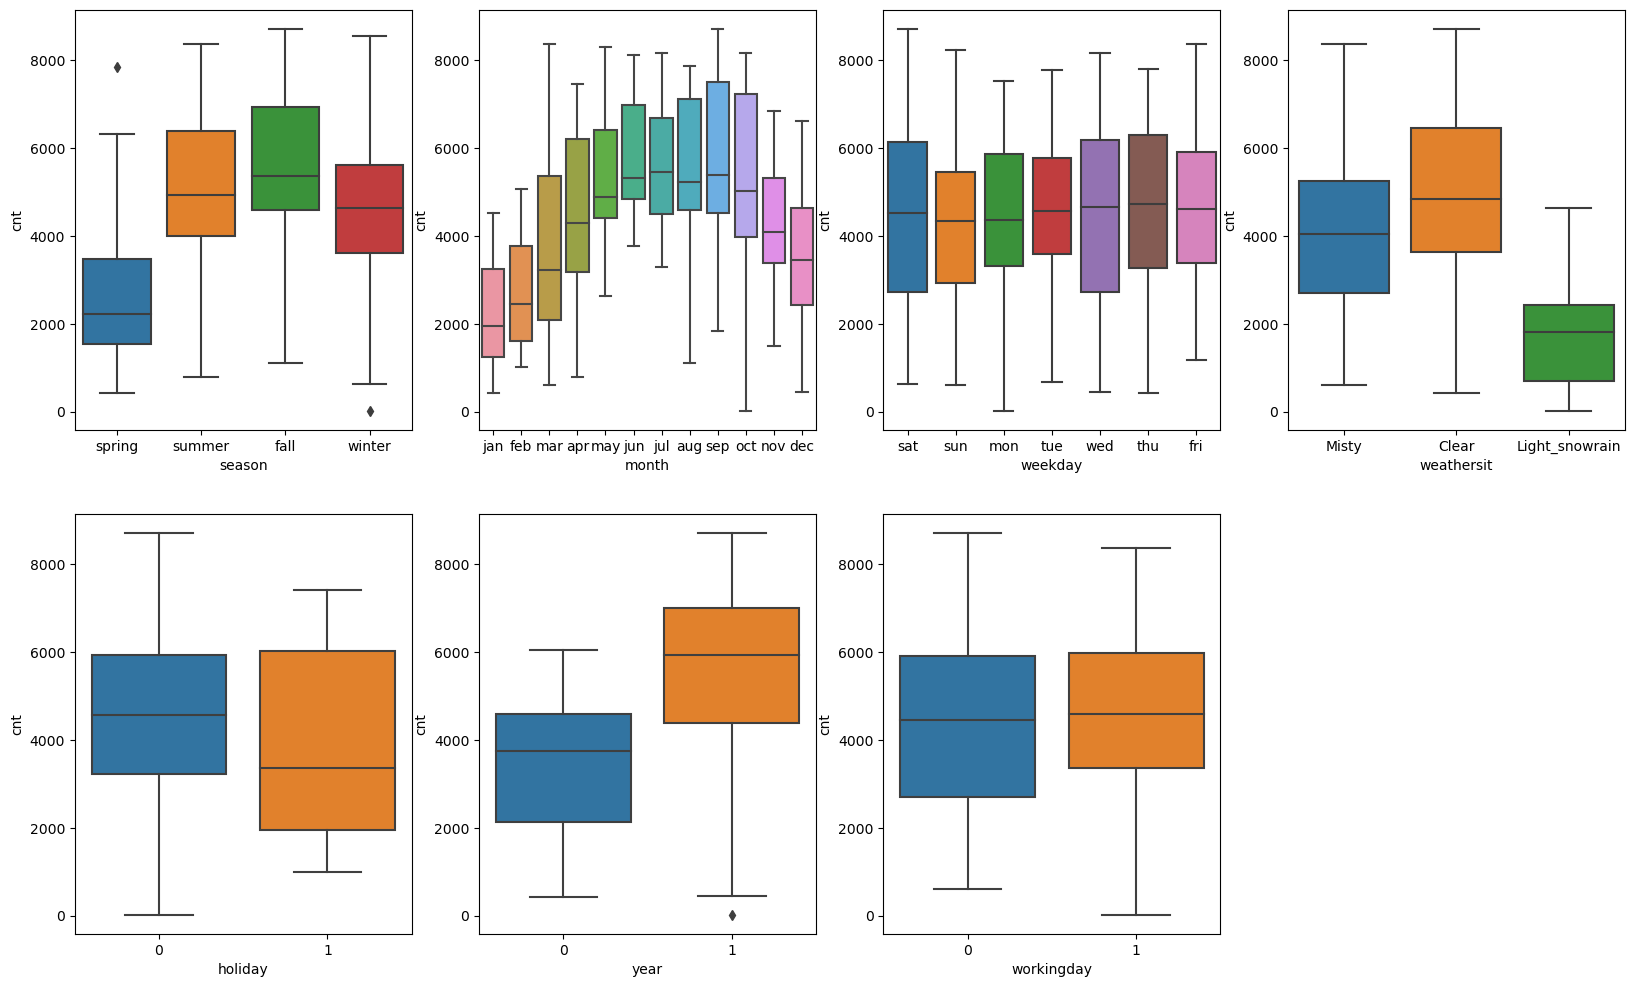

In [21]:
plt.figure(figsize=(20,12))
plt.subplot(2,4,1)
sns.boxplot(x='season',y='cnt',data=bike)
plt.subplot(2,4,2)
sns.boxplot(x='month',y='cnt',data=bike)
plt.subplot(2,4,3)
sns.boxplot(x='weekday',y='cnt',data=bike)
plt.subplot(2,4,4)
sns.boxplot(x='weathersit',y='cnt',data=bike)
plt.subplot(2,4,5)
sns.boxplot(x='holiday',y='cnt',data=bike)
plt.subplot(2,4,6)
sns.boxplot(x='year',y='cnt',data=bike)
plt.subplot(2,4,7)
sns.boxplot(x='workingday',y='cnt',data=bike)

In [22]:
def plot_cat_columns(column):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.barplot(x=column,y='cnt',data=bike)
    plt.subplot(1,2,2)
    sns.barplot(x=column,y='cnt',data=bike,hue='year',palette='Set1')
    plt.legend(labels=['2018','2019'])
    plt.show()
    

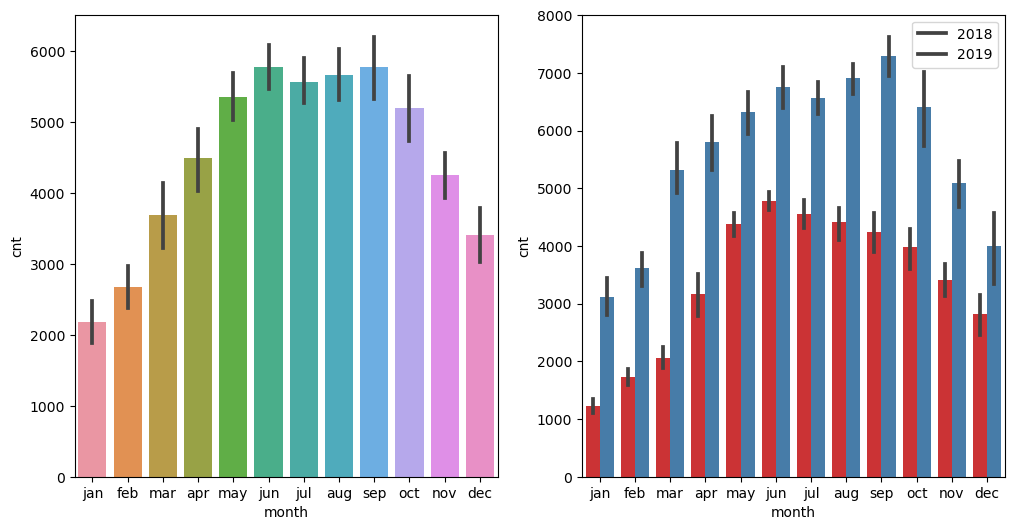

In [23]:
plot_cat_columns('month')

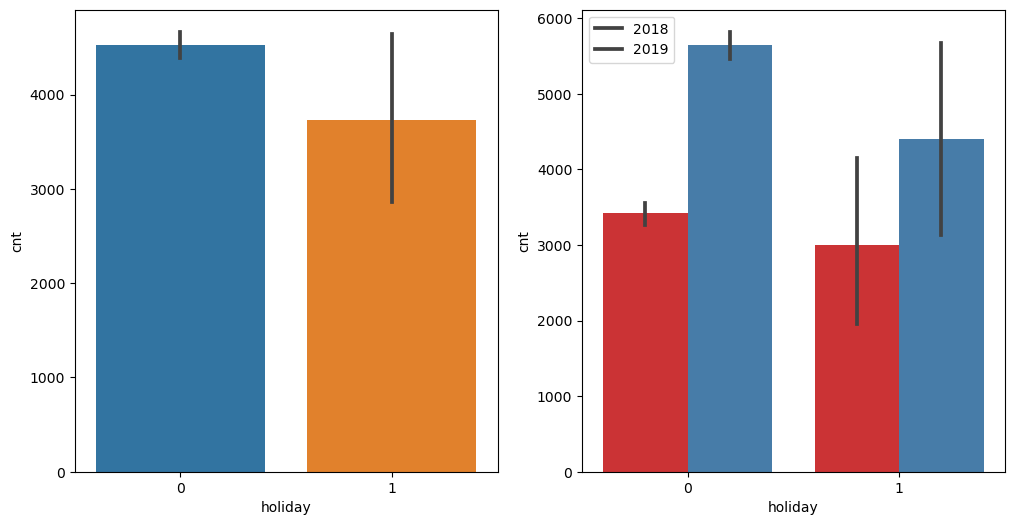

In [24]:
plot_cat_columns('holiday')

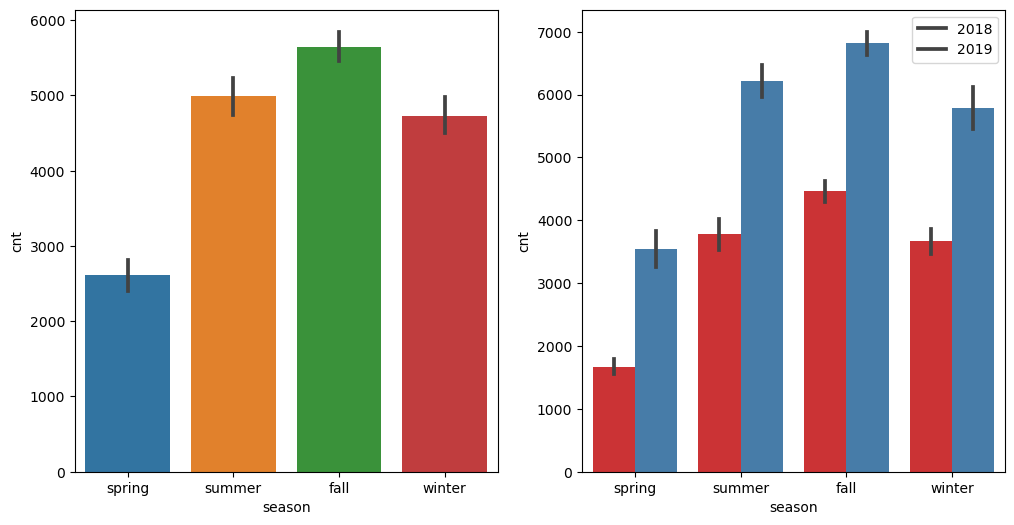

In [25]:
plot_cat_columns('season')

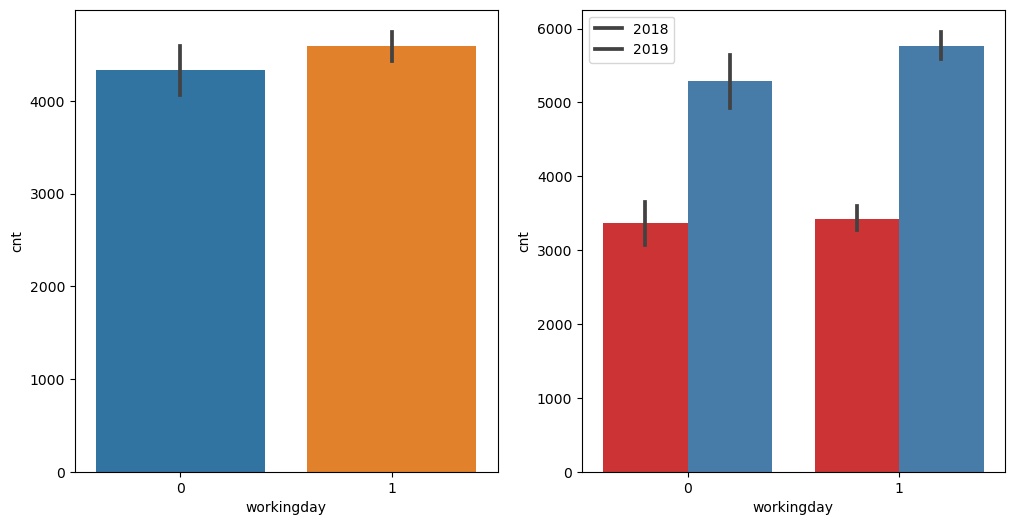

In [26]:
plot_cat_columns('workingday')

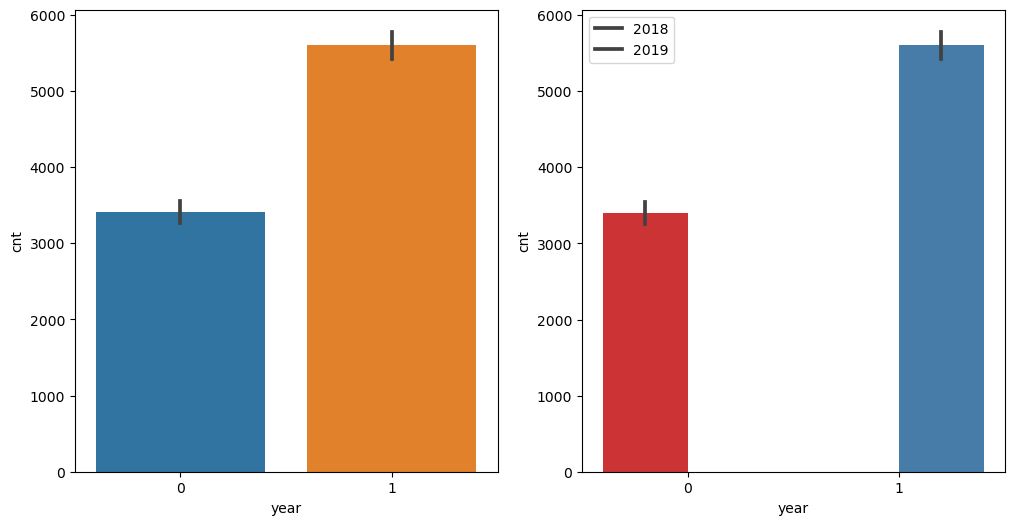

In [27]:
plot_cat_columns('year')

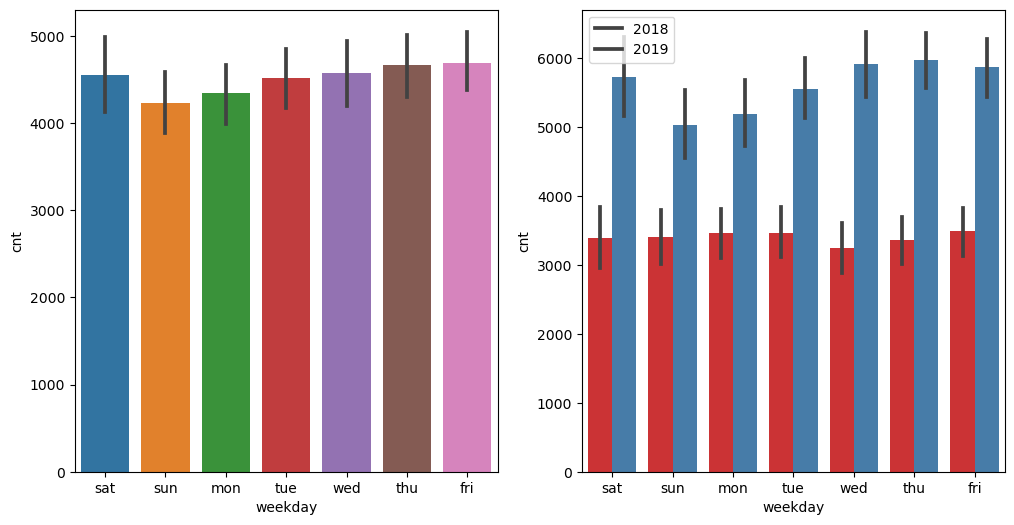

In [28]:
plot_cat_columns('weekday')

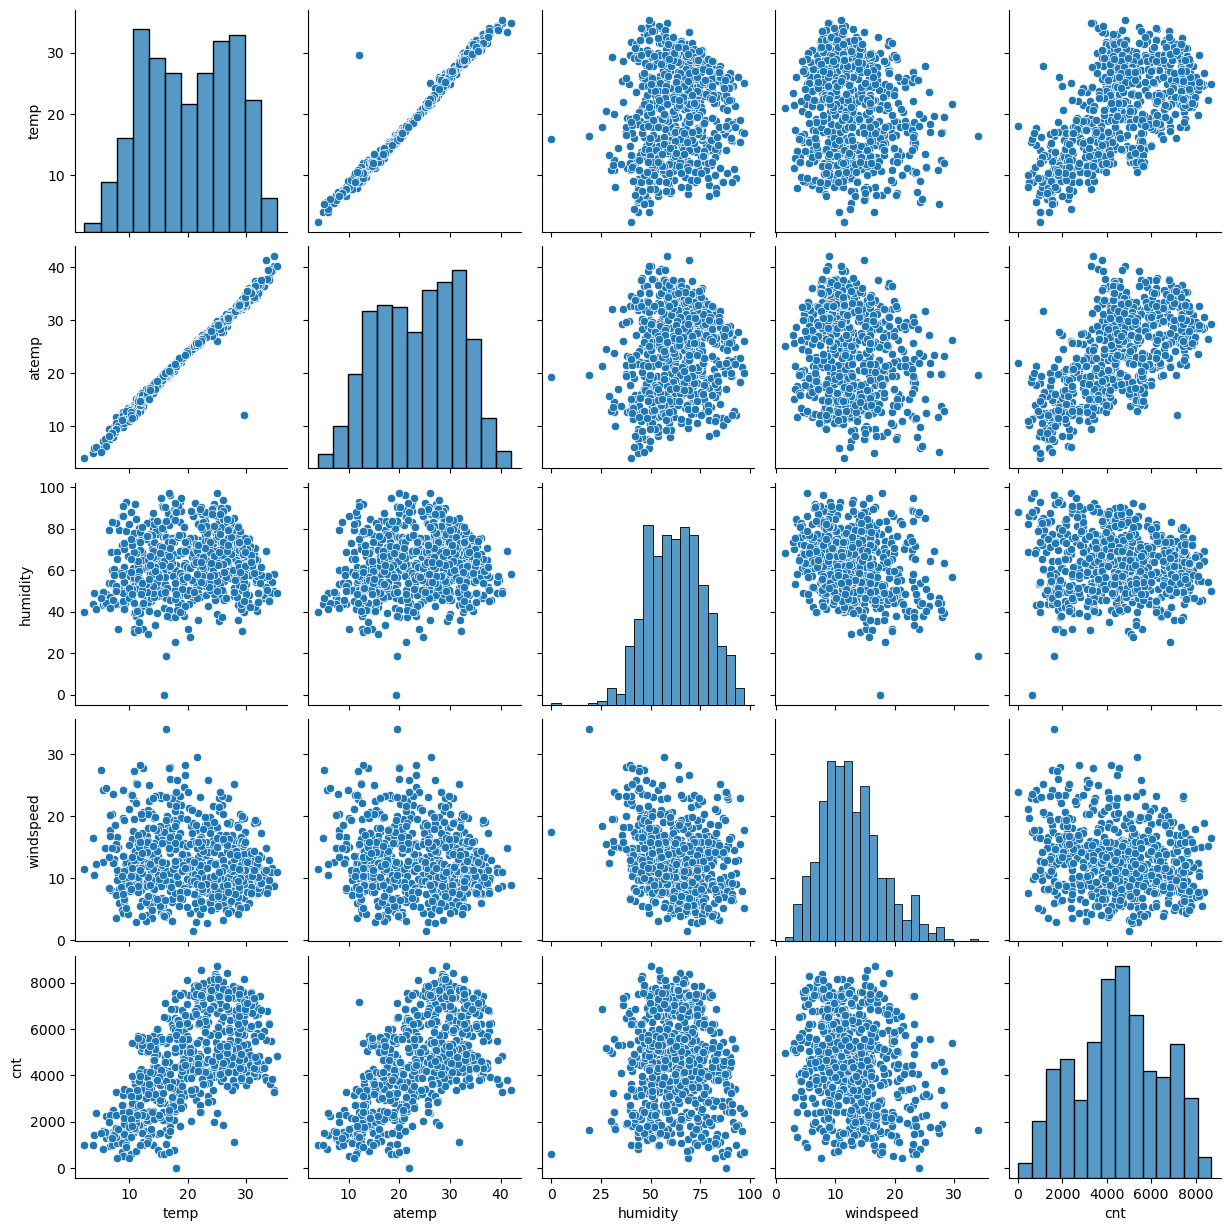

In [29]:
###STEP 2:Visualising the Data
sns.pairplot(bike,vars=['temp','atemp','humidity','windspeed','cnt'])
plt.show()

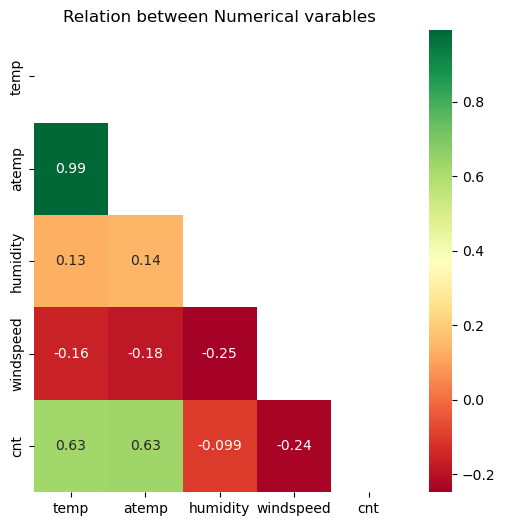

In [30]:
plt.figure(figsize=(6,6))
matrix=np.triu(bike[['temp','atemp','humidity','windspeed','cnt']].corr())
sns.heatmap(bike[['temp','atemp','humidity','windspeed','cnt']].corr(),annot=True,cmap="RdYlGn",mask=matrix)
plt.title("Relation between Numerical varables")
plt.show()


In [31]:
###STEP #: Data preparation
#dummy variable creation
months_df=pd.get_dummies(bike.month,drop_first=True)
weekdays_df=pd.get_dummies(bike.weekday,drop_first=True)
weathersit_df=pd.get_dummies(bike.weathersit,drop_first=True)
seasons_df=pd.get_dummies(bike.season,drop_first=True)

In [32]:
bike.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [33]:
bike_new = pd.concat([bike,months_df,weekdays_df,weathersit_df,seasons_df],axis=1)
bike_new.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,...,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
0,spring,0,jan,0,sat,0,Misty,14.110847,18.18125,80.5833,...,True,False,False,False,False,False,True,True,False,False
1,spring,0,jan,0,sun,0,Misty,14.902598,17.68695,69.6087,...,False,True,False,False,False,False,True,True,False,False
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,...,False,False,False,False,False,False,False,True,False,False
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,...,False,False,False,True,False,False,False,True,False,False
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,...,False,False,False,False,True,False,False,True,False,False


In [34]:
bike_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          730 non-null    object 
 1   year            730 non-null    int64  
 2   month           730 non-null    object 
 3   holiday         730 non-null    int64  
 4   weekday         730 non-null    object 
 5   workingday      730 non-null    int64  
 6   weathersit      730 non-null    object 
 7   temp            730 non-null    float64
 8   atemp           730 non-null    float64
 9   humidity        730 non-null    float64
 10  windspeed       730 non-null    float64
 11  cnt             730 non-null    int64  
 12  aug             730 non-null    bool   
 13  dec             730 non-null    bool   
 14  feb             730 non-null    bool   
 15  jan             730 non-null    bool   
 16  jul             730 non-null    bool   
 17  jun             730 non-null    boo

In [35]:
bike_new.drop(['season','month','weekday','weathersit'],axis=1,inplace=True)


In [36]:
bike_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            730 non-null    int64  
 1   holiday         730 non-null    int64  
 2   workingday      730 non-null    int64  
 3   temp            730 non-null    float64
 4   atemp           730 non-null    float64
 5   humidity        730 non-null    float64
 6   windspeed       730 non-null    float64
 7   cnt             730 non-null    int64  
 8   aug             730 non-null    bool   
 9   dec             730 non-null    bool   
 10  feb             730 non-null    bool   
 11  jan             730 non-null    bool   
 12  jul             730 non-null    bool   
 13  jun             730 non-null    bool   
 14  mar             730 non-null    bool   
 15  may             730 non-null    bool   
 16  nov             730 non-null    bool   
 17  oct             730 non-null    boo

In [37]:
bike_new.shape

(730, 30)

In [38]:
##4. Splitting the data into training and testing sets
np.random.seed(0)

In [39]:
df_train,df_test = train_test_split(bike_new,train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


In [40]:
scaler = MinMaxScaler()

In [41]:
df_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,False,False,...,False,False,False,True,False,False,False,False,False,False
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,False,False,...,True,False,False,False,False,False,True,True,False,False
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,False,True,...,False,True,False,False,False,False,False,True,False,False
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,False,False,...,True,False,False,False,False,False,True,False,True,False
111,0,0,1,13.803347,16.0977,72.9583,14.707907,1683,False,False,...,False,False,False,False,False,False,True,False,True,False


In [42]:
num_vars = [ 'temp', 'atemp', 'humidity', 'windspeed','cnt']
df_train[num_vars]= scaler.fit_transform(df_train[num_vars])


In [43]:
df_train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,Light_snowrain,Misty,spring,summer,winter
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,False,False,...,False,False,False,True,False,False,False,False,False,False
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,False,False,...,True,False,False,False,False,False,True,True,False,False
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,False,True,...,False,True,False,False,False,False,False,True,False,False
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,False,False,...,True,False,False,False,False,False,True,False,True,False
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,False,False,...,False,False,False,False,False,False,True,False,True,False


In [44]:
df_train.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


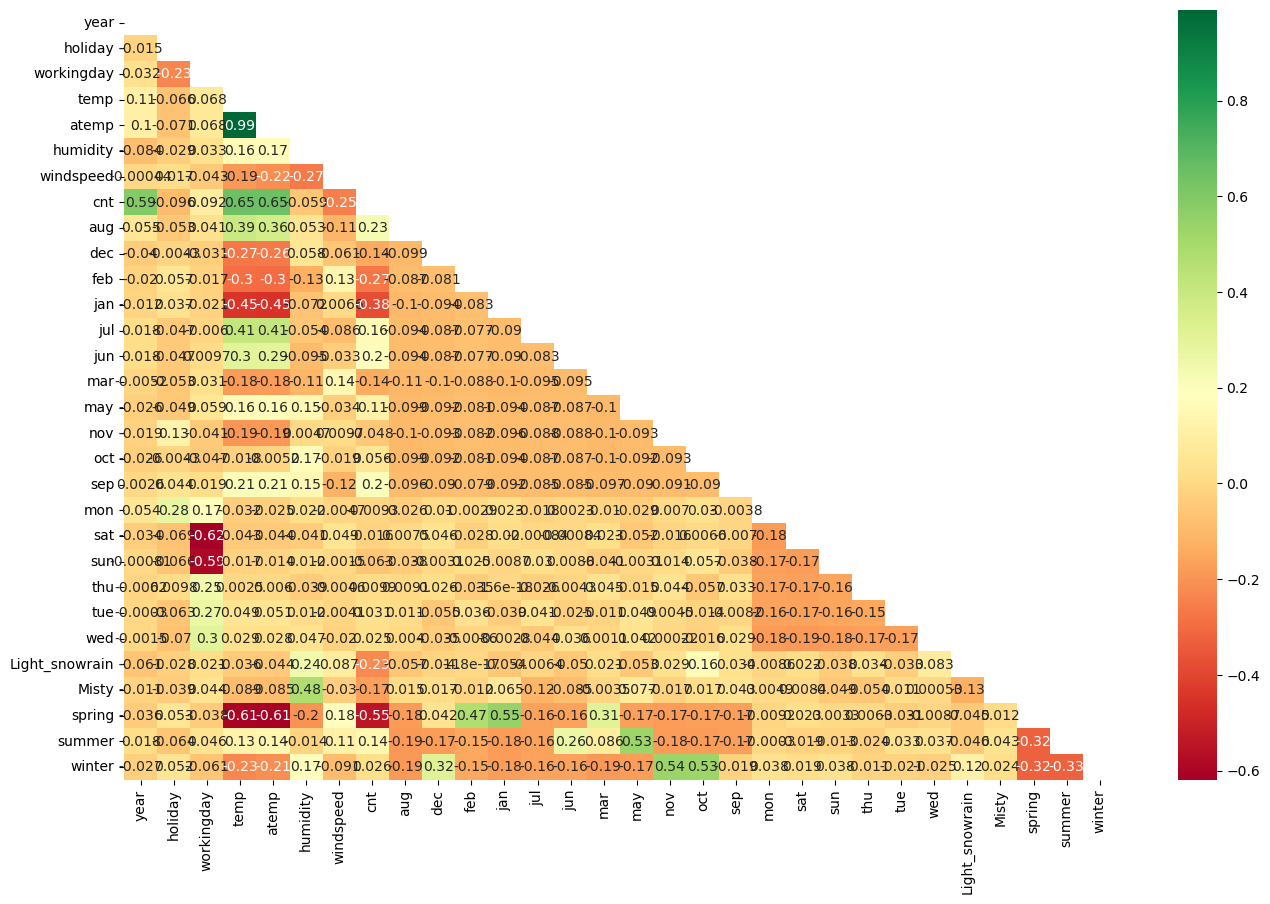

In [45]:
plt.figure(figsize =(16,10))
matrix=np.triu(df_train.corr())
sns.heatmap(df_train.corr(),annot = True,cmap="RdYlGn",mask=matrix)
plt.show()

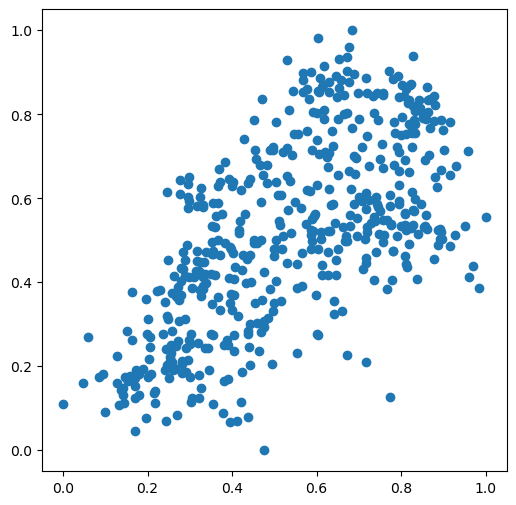

In [46]:
plt.figure(figsize =[6,6])
plt.scatter(df_train.temp,df_train.cnt)
plt.show()

In [47]:
y_train = df_train.pop('cnt')
X_train = df_train


In [48]:
#recursive feature elimination
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm)
rfe=rfe.fit(X_train,y_train)

In [49]:
#List of variables selected in top 15 list

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 9),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('aug', True, 1),
 ('dec', False, 4),
 ('feb', False, 3),
 ('jan', False, 2),
 ('jul', False, 7),
 ('jun', False, 16),
 ('mar', False, 8),
 ('may', False, 6),
 ('nov', False, 5),
 ('oct', False, 11),
 ('sep', True, 1),
 ('mon', False, 15),
 ('sat', True, 1),
 ('sun', True, 1),
 ('thu', False, 13),
 ('tue', False, 10),
 ('wed', False, 12),
 ('Light_snowrain', True, 1),
 ('Misty', True, 1),
 ('spring', False, 14),
 ('summer', True, 1),
 ('winter', True, 1)]

In [50]:
# selecting the selected variable via RFE in col list

col = X_train.columns[rfe.support_]
print(col)

Index(['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'aug',
       'sep', 'sat', 'sun', 'Light_snowrain', 'Misty', 'summer', 'winter'],
      dtype='object')


In [51]:
X_train.columns[~rfe.support_]

Index(['atemp', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
       'mon', 'thu', 'tue', 'wed', 'spring'],
      dtype='object')

In [52]:
# calculating VIF for the variables
def calculateVIF(bike):
    vif= pd.DataFrame()
    bike = bike.select_dtypes(include='number')  # Select only numeric columns
    bike = bike.fillna(0)  # Impute missing values with 0 (adjust as needed)
    vif['Features']=bike.columns
    vif['VIF']=[variance_inflation_factor(bike.values,i) for i in range(bike.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif=vif.sort_values(by="VIF",ascending=False)
    return vif

In [53]:
X_train_rfe = X_train[col]

In [54]:
X_train_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 576 to 520
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            510 non-null    int64  
 1   holiday         510 non-null    int64  
 2   workingday      510 non-null    int64  
 3   temp            510 non-null    float64
 4   humidity        510 non-null    float64
 5   windspeed       510 non-null    float64
 6   aug             510 non-null    bool   
 7   sep             510 non-null    bool   
 8   sat             510 non-null    bool   
 9   sun             510 non-null    bool   
 10  Light_snowrain  510 non-null    bool   
 11  Misty           510 non-null    bool   
 12  summer          510 non-null    bool   
 13  winter          510 non-null    bool   
dtypes: bool(8), float64(3), int64(3)
memory usage: 31.9 KB


In [55]:
calculateVIF(X_train_rfe)

,Features,VIF
4,humidity,8.75
3,temp,6.41
5,windspeed,3.45
2,workingday,3.13
0,year,2.01
1,holiday,1.07


In [56]:
##Step 5 :building a linear model
X_train_rfe = X_train[col]

In [87]:
X_train_rfe['aug'] = pd.to_numeric(X_train_rfe['aug'], errors='coerce')  # Handle non-numeric values
X_train_rfe['sep'] = pd.to_numeric(X_train_rfe['sep'], errors='coerce')  # Handle non-numeric values
X_train_rfe['sat'] = pd.to_numeric(X_train_rfe['sat'], errors='coerce')  # Handle non-numeric values
X_train_rfe['sun'] = pd.to_numeric(X_train_rfe['sun'], errors='coerce')  # Handle non-numeric values
X_train_rfe['Light_snowrain'] = pd.to_numeric(X_train_rfe['Light_snowrain'], errors='coerce')  # Handle non-numeric values
X_train_rfe['Misty'] = pd.to_numeric(X_train_rfe['Misty'], errors='coerce')  # Handle non-numeric values
X_train_rfe['summer'] = pd.to_numeric(X_train_rfe['summer'], errors='coerce')  # Handle non-numeric values
X_train_rfe['winter'] = pd.to_numeric(X_train_rfe['winter'], errors='coerce')  # Handle non-numeric values




In [99]:
series = float(X_train_rfe.aug)
 #   ['aug','sep', 'sat', 'sun', 'Light_snowrain', 'Misty', 'summer', 'winter']])


print(series)

TypeError: cannot convert the series to <class 'float'>

In [94]:
X_train_rfe = (pd.series(['aug',
       'sep', 'sat', 'sun', 'Light_snowrain', 'Misty', 'summer', 'winter'])).astype(float)
                      
    
    

AttributeError: module 'pandas' has no attribute 'series'

In [88]:
def build_model(cols):
    X_train_sm = sm.add_constant(X_train_rfe)
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [89]:
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = bike.columns
    vif['VIF'] = [variance_inflation_factor(bike.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [91]:
#build model1:
cols = ['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'spring',
       'summer', 'winter', 'jan', 'jul', 'sept', 'sat',
       'weathersit']

build_model(cols)
get_vif(cols)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [92]:
X_train_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 576 to 520
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            510 non-null    int64  
 1   holiday         510 non-null    int64  
 2   workingday      510 non-null    int64  
 3   temp            510 non-null    float64
 4   humidity        510 non-null    float64
 5   windspeed       510 non-null    float64
 6   aug             510 non-null    bool   
 7   sep             510 non-null    bool   
 8   sat             510 non-null    bool   
 9   sun             510 non-null    bool   
 10  Light_snowrain  510 non-null    bool   
 11  Misty           510 non-null    bool   
 12  summer          510 non-null    bool   
 13  winter          510 non-null    bool   
dtypes: bool(8), float64(3), int64(3)
memory usage: 31.9 KB


In [ ]:
lr_model.summary()

In [ ]:
#VIF
X_train_sm = sm.add_constant(X_train[['atemp','yr','mnth']])
lr=sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.summary()

In [ ]:
#VIF
X_train_sm = sm.add_constant(X_train[[ 'instant','yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum']])
lr=sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.summary()

In [ ]:
bike.columns